In [72]:
import cv2
import time

import numpy as np
import math

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import colors
%matplotlib inline

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

In [48]:
def detect_image(img, template, plot_enable):
    img2 = img.copy()
    w, h = template.shape[::-1]
    
    img = img2.copy()
    method = cv2.TM_SQDIFF_NORMED

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    #take minimum
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, (0,0,255), 7)

    if plot_enable:
        plt.figure()
        ax4 = plt.subplot(121),plt.imshow(res, cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax5 = plt.subplot(122),plt.imshow(img, cmap = 'gray')
        plt.title('Detected picture'), plt.xticks([]), plt.yticks([])
        plt.suptitle(method)
        
        plt.show()
        
    center = [(top_left[0] + bottom_right[0])/2, (top_left[1] + bottom_right[1])/2]
    return center #coordinates of the center of the image.

In [49]:
def filtering(name_img, plot_enable):
    photo = cv2.imread(name_img)
    bilateral = cv2.bilateralFilter(photo,9,75,75)

    bw_photo = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

    #th2 = cv2.adaptiveThreshold(bw_photo,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
    #           cv2.THRESH_BINARY,11,2)
    #th3 = cv2.adaptiveThreshold(bw_photo,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,101,4)
    ret2,th2 = cv2.threshold(cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if plot_enable:
        '''fig, ax = plt.subplots(1,2, figsize=(8,4))

        ax[0][0].imshow(photo[:,:,::-1], 'gray')
        ax[0][0].set_title("Original")

        ax[0][1].imshow(th2, 'gray')
        ax[0][1].set_title("Filtered")

        plt.show()'''
        plt.figure()
        ax = plt.subplot(121),plt.imshow(photo[:,:,::-1], cmap = 'gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        ax1 = plt.subplot(122),plt.imshow(th2, cmap = 'gray')
        plt.title('Filtered image'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    return th2

In [50]:
def detect_multiple(name_img, img, template, threshold, plot_enable):
    
    img_gray = img
    img_rgb = cv2.imread(name_img, cv2.IMREAD_COLOR)
    
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)

    loc = np.where( res <= threshold)

    pt_prec = [loc[1][0], loc[0][0]]
    
    list_pt = [pt_prec] #take 1st point
    #draw rectangle for first point
    cv2.rectangle(img_rgb, (pt_prec[0], pt_prec[1]), (int(pt_prec[0] + w), int(pt_prec[1] + h)), (255,0,0), 5)
    
    #list of extra point we don't want
    pt_notchoosen = []

    for pt in zip(*loc[::-1]):
        #if not too close of the previous choosen point, might be a new obstacle
        if (abs(pt[0] - pt_prec[0]) > 1) or (abs(pt[1] - pt_prec[1]) > 1) :
            
            same_obstacle = 0
            #if too close of not wanted point, not a new obstacle, we don't want it
            for pt_not in pt_notchoosen:
                if (abs(pt[0] - pt_not[0]) <=10) and (abs(pt[1] - pt_not[1]) <= 10):
                    same_obstacle = 1
                    pt_notchoosen.append([pt[0], pt[1]])
                    break
            #if not too close, we add it to the list, draw a rectangle and update pt_prec
            if not same_obstacle : 
                list_pt.append([pt[0], pt[1]])
                cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 5)
                pt_prec = pt
        else:
            pt_notchoosen.append([pt[0], pt[1]])
                    
    
    #cv2.imwrite('res.png',img_rgb)
    if plot_enable:
        plt.figure()
        ax2 = plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax3 = plt.subplot(122),plt.imshow(img_rgb,cmap = 'gray')
        plt.title('Detected obstacles'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    #list_pt contains the coordinates of the top left corners of all the objects    
    return list_pt, w, h

**Coordonnées des obstacles/peintures/coins**

In [67]:
def get_param():
    name_carte ='structure/cartecoin.png'
    name_picture = 'oeuvres/triangle.png'
    name_obstacle = 'structure/obstacle.png'
    name_corner = 'structure/coin.png'
    
    #G R I D
    max_val_x = 14 # nm of square of 6 cm
    max_val_y = 10
    
    carte = cv2.imread(name_carte,0)
    picture = cv2.imread(name_picture,0)
    obstacle = cv2.imread(name_obstacle,0)
    corner = cv2.imread(name_corner,0)
    plot_enable = False


    #filter images
    carte_filtered = filtering(name_carte, plot_enable)
    picture_filtered = filtering(name_picture, plot_enable)
    obstacle_filtered = filtering(name_obstacle, plot_enable)
    corner_filtered = filtering(name_corner, plot_enable)

    #get coordinates of pictures and obstacles
    list_paintings = detect_image(carte_filtered, picture_filtered, plot_enable)
    list_obstacles,w_obst,h_obst = detect_multiple(name_carte, carte_filtered, obstacle_filtered, 0.8 , plot_enable)
    list_corners, w_corner, h_corner = detect_multiple(name_carte, carte_filtered, corner_filtered, 0.2, plot_enable)
    
    return list_paintings, list_obstacles, w_obst, h_obst, list_corners, w_corner, h_corner, max_val_x, max_val_y

**GRILLE**

Environnement delimitation

In [64]:
def get_rectangle(list_corners, w_corner, h_corner):
    #prendre le plus petit rectangle décrit par les coins
    sort_corners = sorted(list_corners) #trie les points selon x
    x1 = max(sort_corners[0][0], sort_corners[1][0])
    x2 = min(sort_corners[2][0], sort_corners[3][0]) + w_corner

    sort_corners = sorted(list_corners , key=lambda k: [k[1], k[0]])
    y1 = max(sort_corners[0][1], sort_corners[1][1])
    y2 = min(sort_corners[2][1], sort_corners[3][1]) + h_corner

    return [[x1,y1],[x2,y2]]

create grid for visualization

In [61]:
def create_visual_grid(max_val_x, max_val_y):
    fig, ax = plt.subplots(figsize=(7,7))

    major_ticks = np.arange(0, max_val_x+1, 10)
    minor_ticks = np.arange(0, max_val_x+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y])
    ax.set_xlim([-1,max_val_x])
    ax.grid(True)
    return fig, ax

Convert into grid coordinate

In [75]:
def convert_to_grid(x,y,list_corners, max_val_x):
    x_grid = max_val_x*(x - list_corners[0][0])/(list_corners[1][0] - list_corners[0][0])
    y_grid = max_val_y*(y - list_corners[0][1])/(list_corners[1][1] - list_corners[0][1])
    return [x_grid,y_grid]

Create The grid and fill it

In [62]:
def create_fill_grid():
    #Occupancy code
    limit_empty = 1 
    obstacle_here = 2
    painting_here = 3

    #Get coordinate
    list_paintings, list_obstacles, w_obst, h_obst, list_corners, w_corner, h_corner, max_val_x, max_val_y = get_param()
    
    #Create visual grid
    fig, ax = create_visual_grid(max_val_x, max_val_y)
    
    # Creating the occupancy grid
    np.random.seed(0) # To guarantee the same outcome on all computers
    data = np.zeros((max_val_x, max_val_y)) # Create an empty grid of max_val_x X max_val_y
    cmap = colors.ListedColormap(['white', 'black', 'red']) # Select the colors: Black = obstacles, Red = painting

    
    #Get environnement delimitations
    list_delimitation = get_rectangle(list_corners, w_corner, h_corner)
    
    #Convert coordinate into grid coordinate
    for obs in list_obstacles:
        obs_grid = convert_to_grid(obs[0], obs[1], list_delimitation, max_val_x)
        data[obs_grid]= obstacle_here

    #Convert coordinate into grid coordinate
    for paint in list_paintings:
        data[paint]= painting_here


    # Converting the random values into occupied and free cells
    occupancy_grid = data.copy()
    occupancy_grid[data==painting_here] = 2
    occupancy_grid[data==obstacle_here] = 1
    occupancy_grid[data==limit_empty] = 0

    #GET THE POSITIONS OF PAINTINGS AND OBSTACLES FROM VISION

    # Displaying the map
    ax.imshow(occupancy_grid.transpose(), cmap=cmap)

IndexError: index 671 is out of bounds for axis 0 with size 14

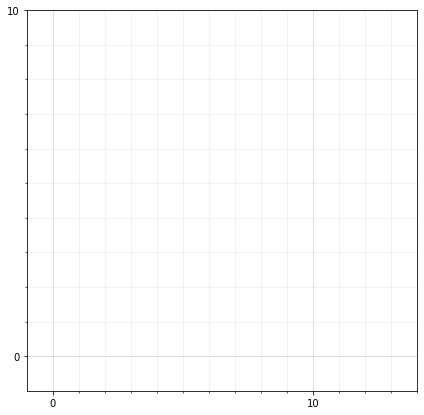

In [63]:
# ------- DELIMITATION DE LA GRILLE -------


# do the G R I D





create_fill_grid()


In [41]:

#REVOIR POUR IMPORTER LA MAP DEPUIS LA PHOTO
limit_empty = 1 
obstacle_here = 2
painting_here = 3

#Creating the grid
#fig, ax = create_empty_plot()

# Creating the occupancy grid
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.zeros((max_val_x, max_val_y)) # Create an empty grid of 168 x 118 values
cmap = colors.ListedColormap(['white', 'black', 'red']) # Select the colors with which to display obstacles and free cells
#Black is the obstacles
#Red is painting


#Convert pos of obstacles into
"""
obstacle_pos = getObstaclePos()
for i in range(0, len(obstacle_pos))
    data[obstacle_pos[0][0], obstacle_pos[0][1]]= obstacle_here
    
painting_pos = getPaintingPos()
for i in range(0, len(painting_pos))
    data[painting_pos[0][0], painting_pos[0][1]]= painting_here
    
"""
data[12,10] = painting_here
data[50,50] = obstacle_here

# Converting the random values into occupied and free cells
occupancy_grid = data.copy()
occupancy_grid[data==painting_here] = 2
occupancy_grid[data==obstacle_here] = 1
occupancy_grid[data==limit_empty] = 0

#GET THE POSITIONS OF PAINTINGS AND OBSTACLES FROM VISION

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)



IndexError: index 10 is out of bounds for axis 1 with size 10

In [74]:
print(math.floor(1.6))

1


**TODO**
-
- grille: itérer sur la taille des obstacles
- traduire la taille en grid ? 
- 
